In [26]:
%load_ext autoreload
%autoreload 2

# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 1 - Predicting Customer Churn in the Telecomunication Provider

## 3. Modeling

### 3.3. Decision Tree - SMOTE

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
X_train = pd.read_csv('../data/processed/SMOTE/X_train.csv')
y_train = pd.read_csv('../data/processed/SMOTE/y_train.csv')
X_val = pd.read_csv('../data/processed/SMOTE/X_val.csv')
y_val = pd.read_csv('../data/processed/SMOTE/y_val.csv')
X_test = pd.read_csv('../data/processed/SMOTE/X_test.csv')
y_test = pd.read_csv('../data/processed/SMOTE/y_test.csv')

In [29]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from joblib import dump

In [32]:
tree = DecisionTreeClassifier(random_state=8)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=8)

In [33]:
def decision_tree(model):
    y_train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_precision = precision_score(y_train, y_train_preds)
    train_recall = recall_score(y_train, y_train_preds)
    train_f1 = f1_score(y_train, y_train_preds)
    train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
    val_accuracy = accuracy_score(y_val, y_val_preds)
    val_precision = precision_score(y_val, y_val_preds)
    val_recall = recall_score(y_val, y_val_preds)
    val_f1 = f1_score(y_val, y_val_preds)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
    train_score = pd.DataFrame({
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1-score': train_f1,
        'roc-auc': train_roc_auc}, index=['Training Set'])
    
    val_score = pd.DataFrame({
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1-score': val_f1,
        'roc-auc': val_roc_auc}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, normalize='true')                                     
    
    plt.figure()
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()
    
    tree_val = pd.DataFrame({'accuracy': val_accuracy,
                             'precision': val_precision,
                             'recall': val_recall,
                             'f1-score': val_f1,
                             'roc-auc': val_roc_auc}, index=['Decision Tree'])
    
    return(tree_val)

In [34]:
def confusion_matrix_plot(X, y, model):
    ConfusionMatrixDisplay.from_estimator(model, X, y, normalize=True)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.820588   0.395161  0.510417  0.445455  0.690996


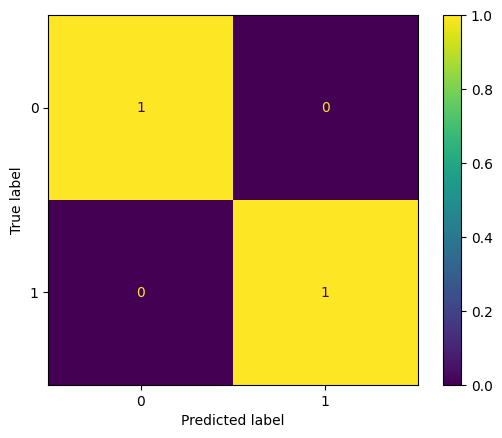

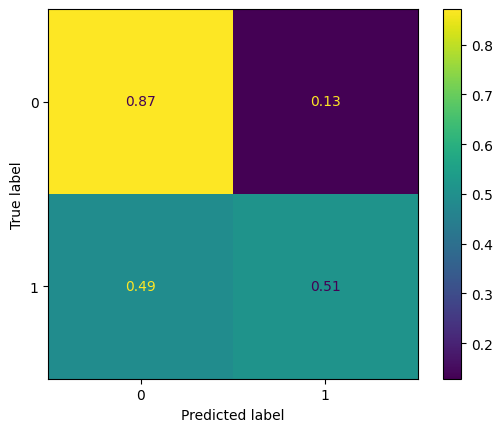

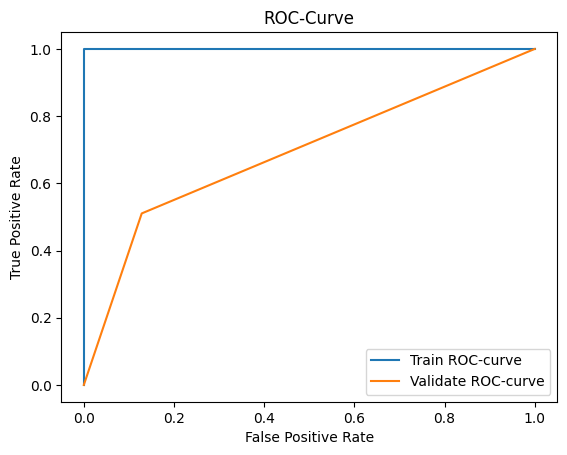

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.820588,0.395161,0.510417,0.445455,0.690996


In [35]:
decision_tree(tree)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with Max depth

default = None

In [36]:
max_depth = [2, 5, 10, 15, 20, 50, 100, 150, 200, None]

In [37]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    tree = DecisionTreeClassifier(random_state=8, max_depth=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2.0,0.673011,0.857353,0.884141,0.490566,0.398204,0.270833,0.549101,0.348993,0.726942,0.674506
5.0,0.794696,0.876471,0.966802,0.642857,0.610351,0.281250,0.748296,0.391304,0.875458,0.749099
10.0,0.910821,0.813235,0.913118,0.383459,0.908041,0.531250,0.910573,0.445415,0.972724,0.750009
15.0,0.988879,0.808824,0.988462,0.367188,0.989307,0.489583,0.988884,0.419643,0.999524,0.708619
20.0,1.000000,0.820588,1.000000,0.395161,1.000000,0.510417,1.000000,0.445455,1.000000,0.690996
50.0,1.000000,0.820588,1.000000,0.395161,1.000000,0.510417,1.000000,0.445455,1.000000,0.690996
100.0,1.000000,0.820588,1.000000,0.395161,1.000000,0.510417,1.000000,0.445455,1.000000,0.690996
150.0,1.000000,0.820588,1.000000,0.395161,1.000000,0.510417,1.000000,0.445455,1.000000,0.690996
200.0,1.000000,0.820588,1.000000,0.395161,1.000000,0.510417,1.000000,0.445455,1.000000,0.690996
NaN,1.000000,0.820588,1.000000,0.395161,1.000000,0.510417,1.000000,0.445455,1.000000,0.690996


In [38]:
def plot_performance(parameter, xlabel):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5))
    
    ax1.plot(parameter, train_accuracy, label='train accuracy')
    ax1.plot(parameter, val_accuracy, label='val accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy Score')
    
    ax2.plot(parameter, train_precision, label='train precision')
    ax2.plot(parameter, val_precision, label='val precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('precision')
    ax2.set_title('Precision Score')
    
    ax3.plot(parameter, train_recall, label='train recall')
    ax3.plot(parameter, val_recall, label='val recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('recall')
    ax3.set_title('Recall Score')
    
    ax4.plot(parameter, train_f1, label='train f1')
    ax4.plot(parameter, val_f1, label='val f1')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('f1')
    ax4.set_title('F1-Score')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    ax5.plot(fpr_train, tpr_train, label='train roc-auc')
    ax5.plot(fpr_val, tpr_val, label='val roc-auc')
    ax5.legend()
    ax5.set_xlabel('false positive rate')
    ax5.set_ylabel('true positive rate')
    ax5.set_title('ROC-AUC Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()    

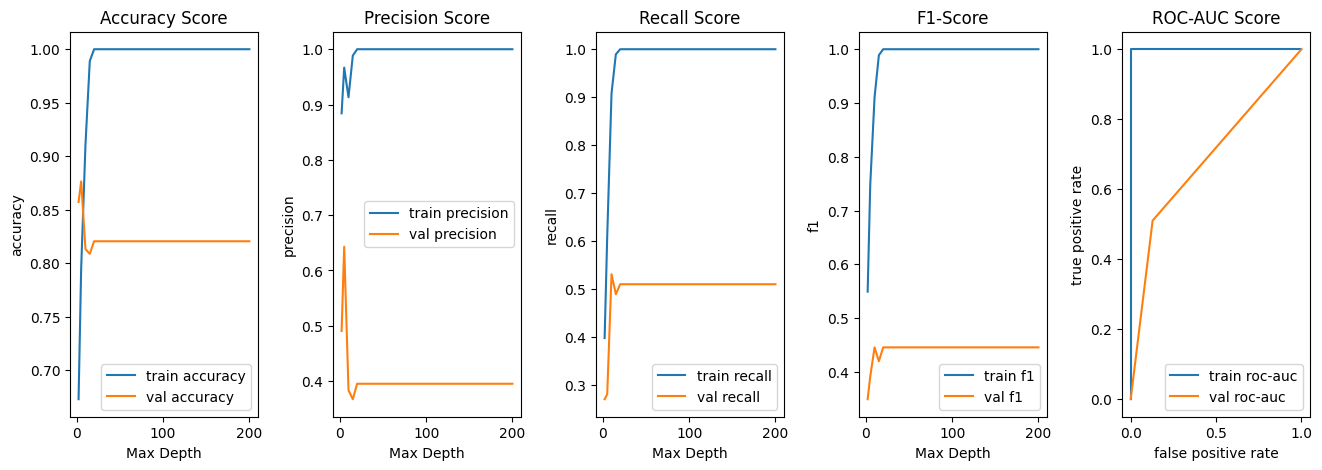

In [39]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 10

In [40]:
tree_max_depth = DecisionTreeClassifier(random_state=8, max_depth=10)
tree_max_depth.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.910821   0.913118  0.908041  0.910573  0.972724
Validation Set  0.813235   0.383459  0.531250  0.445415  0.750009


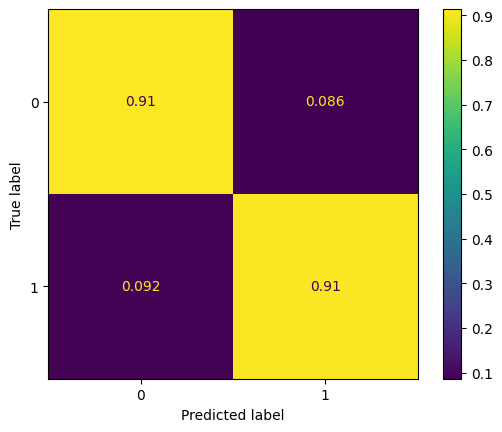

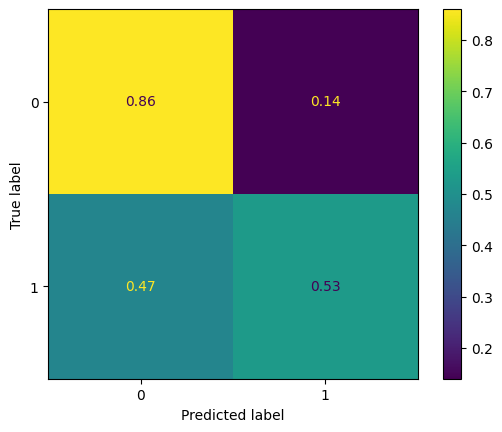

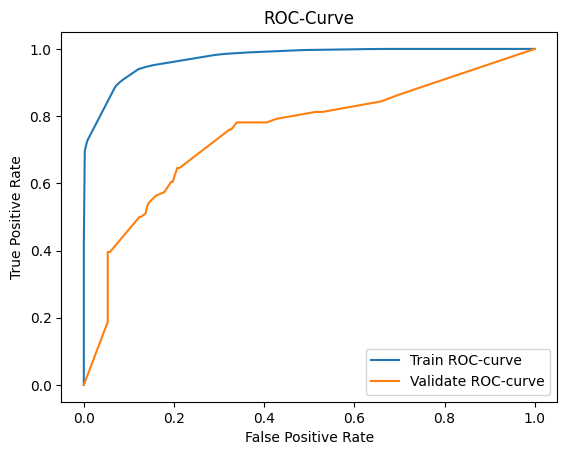

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.813235,0.383459,0.53125,0.445415,0.750009


In [41]:
decision_tree(tree_max_depth)

### Reduce Overfitting with min samples split

default = 2

In [42]:
min_samples_split = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [43]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    tree = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.910821,0.813235,0.913118,0.383459,0.908041,0.531250,0.910573,0.445415,0.972724,0.750009
5,0.908041,0.813235,0.910499,0.381679,0.905047,0.520833,0.907765,0.440529,0.971230,0.742999
10,0.905475,0.814706,0.907917,0.386364,0.902481,0.531250,0.905191,0.447368,0.969617,0.769790
20,0.893926,0.807353,0.893254,0.372263,0.894782,0.531250,0.894017,0.437768,0.963098,0.765786
50,0.877032,0.816176,0.881437,0.389313,0.871257,0.531250,0.876317,0.449339,0.951032,0.754067
100,0.859923,0.832353,0.890487,0.413462,0.820787,0.447917,0.854218,0.430000,0.934619,0.757964
150,0.852224,0.820588,0.873808,0.385965,0.823353,0.458333,0.847831,0.419048,0.931325,0.753576
200,0.852224,0.820588,0.873808,0.385965,0.823353,0.458333,0.847831,0.419048,0.930816,0.754664
250,0.847947,0.826471,0.882104,0.396226,0.803251,0.437500,0.840833,0.415842,0.928228,0.752096
300,0.846878,0.830882,0.881827,0.407767,0.801112,0.437500,0.839534,0.422111,0.926790,0.758267


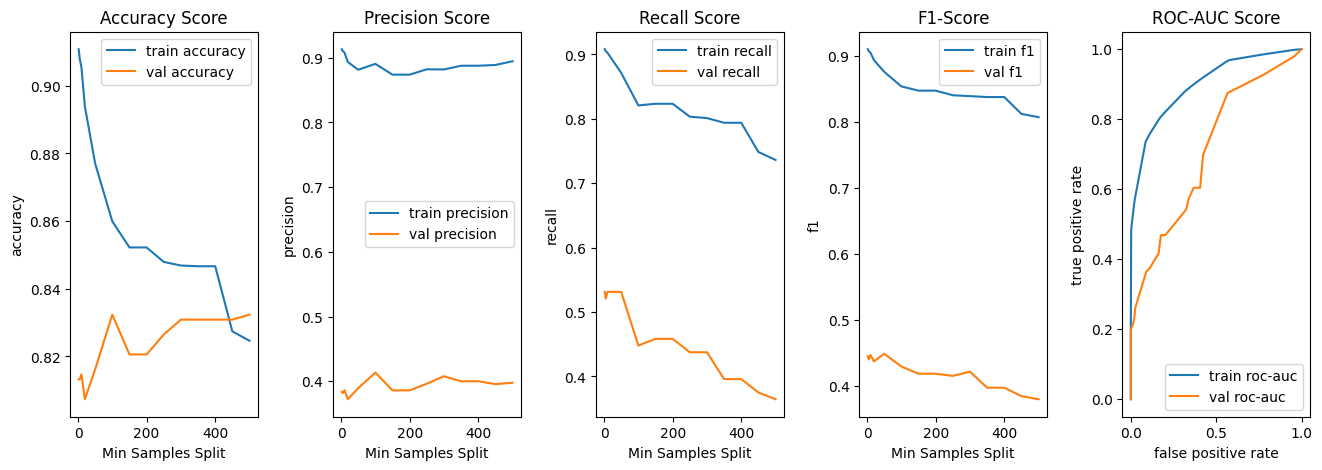

In [44]:
plot_performance(min_samples_split, 'Min Samples Split')

#### min_samples_split = 10

In [45]:
tree_min_samples_split = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=10)
tree_min_samples_split.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.905475   0.907917  0.902481  0.905191  0.969617
Validation Set  0.814706   0.386364  0.531250  0.447368  0.769790


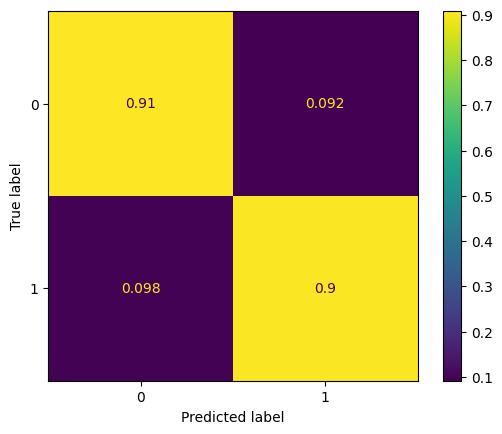

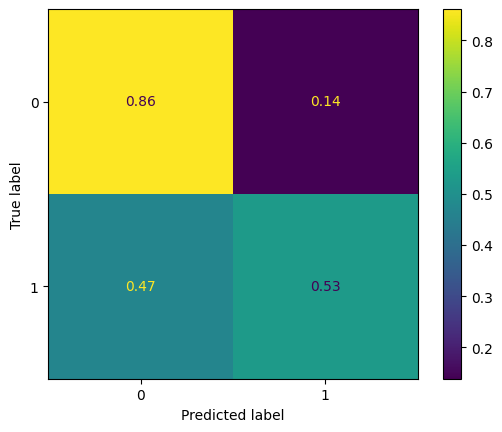

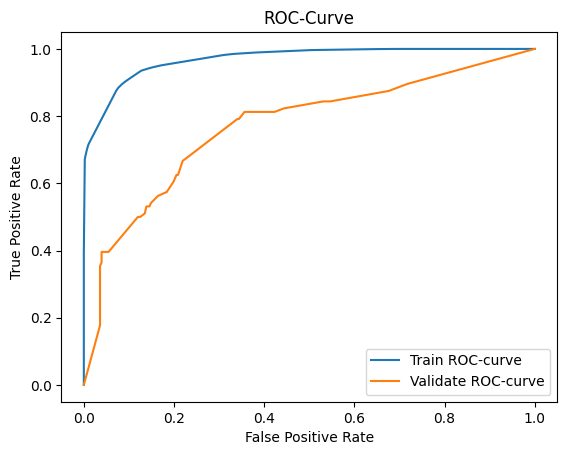

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.814706,0.386364,0.53125,0.447368,0.76979


In [46]:
decision_tree(tree_min_samples_split)

### Reduce Overfitting with max_features

default = None

In [47]:
max_features = ['auto', 'sqrt', 'log2', None]

In [48]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    tree = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=10, max_features=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.866766,0.722059,0.844516,0.253968,0.899059,0.50000,0.870934,0.336842,0.947019,0.662707
sqrt,0.866766,0.722059,0.844516,0.253968,0.899059,0.50000,0.870934,0.336842,0.947019,0.662707
log2,0.846450,0.738235,0.838912,0.277174,0.857571,0.53125,0.848139,0.364286,0.929650,0.717680
None,0.905475,0.814706,0.907917,0.386364,0.902481,0.53125,0.905191,0.447368,0.969617,0.769790


### Reduce Overfitting with criterion

default = gini

In [49]:
criterion = ['gini', 'entropy', 'log_loss']

In [50]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in criterion:
    tree = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=10, max_features=None, criterion=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_criterion = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=criterion)

tune_criterion

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
gini,0.905475,0.814706,0.907917,0.386364,0.902481,0.531250,0.905191,0.447368,0.969617,0.769790
entropy,0.901625,0.829412,0.902659,0.426471,0.900342,0.604167,0.901499,0.500000,0.970156,0.786779
log_loss,0.901625,0.829412,0.902659,0.426471,0.900342,0.604167,0.901499,0.500000,0.970156,0.786779


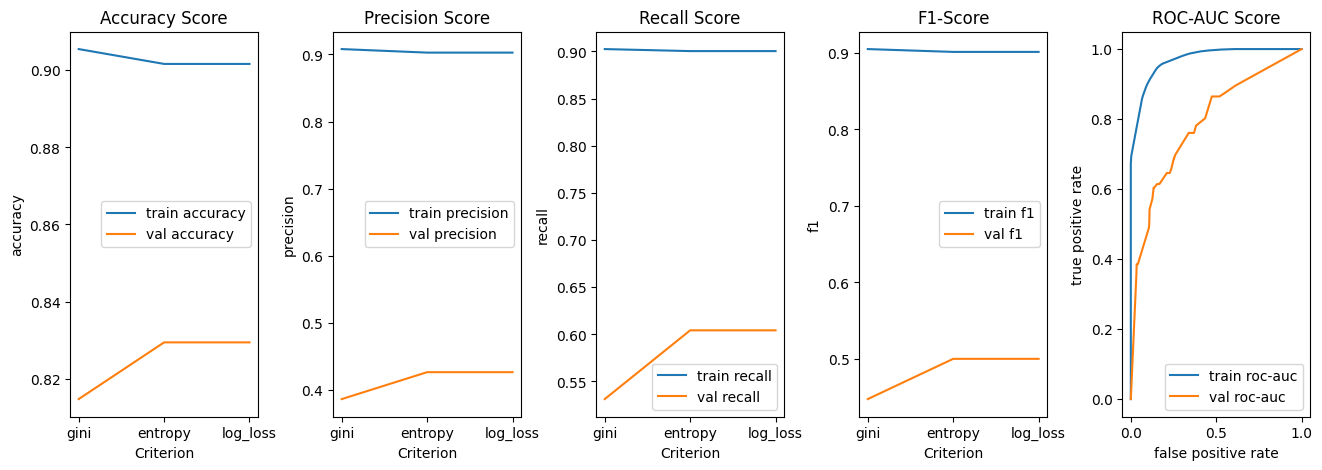

In [51]:
plot_performance(criterion, 'Criterion')

#### criterion = 'entropy'

In [52]:
tree_criterion = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=10, max_features=None, criterion='entropy')
tree_criterion.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.901625   0.902659  0.900342  0.901499  0.970156
Validation Set  0.829412   0.426471  0.604167  0.500000  0.786779


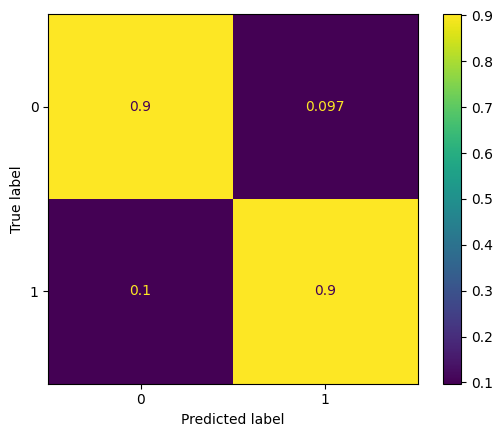

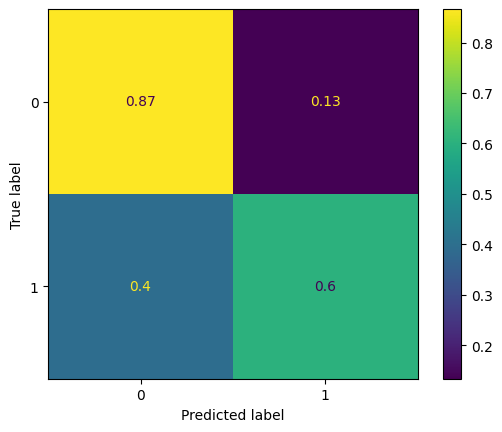

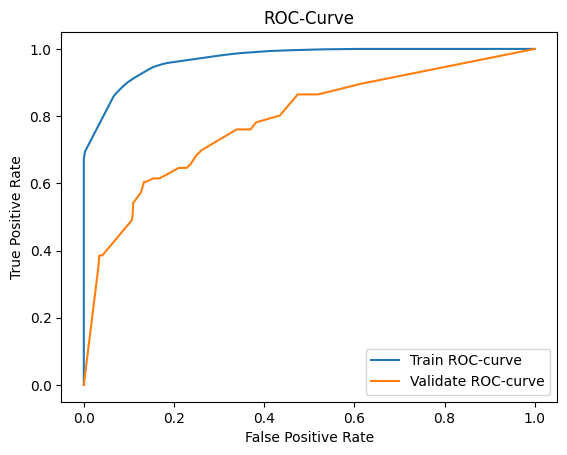

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.829412,0.426471,0.604167,0.5,0.786779


In [53]:
decision_tree(tree_criterion)

### Reduce overfitting with Minimum Impurity Decrease

In [54]:
min_impurity_decrease = [0, 0.00025, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

In [55]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_impurity_decrease:
    tree = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=10, max_features=None, criterion='entropy', min_impurity_decrease=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_impurity_decrease = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_impurity_decrease)

tune_impurity_decrease

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.00000,0.901625,0.829412,0.902659,0.426471,0.900342,0.604167,0.901499,0.500000,0.970156,0.786779
0.00025,0.901625,0.829412,0.902659,0.426471,0.900342,0.604167,0.901499,0.500000,0.970156,0.786779
0.00050,0.901625,0.829412,0.902659,0.426471,0.900342,0.604167,0.901499,0.500000,0.970156,0.786779
0.00100,0.901625,0.829412,0.902659,0.425373,0.900342,0.593750,0.901499,0.495652,0.968828,0.789455
0.00500,0.848589,0.852941,0.911616,0.476190,0.772027,0.416667,0.836035,0.444444,0.914061,0.747833
0.01000,0.812660,0.773529,0.812660,0.323171,0.812660,0.552083,0.812660,0.407692,0.884464,0.734883
0.05000,0.658255,0.832353,0.857143,0.367647,0.379812,0.260417,0.526378,0.304878,0.658255,0.593393
0.10000,0.658255,0.832353,0.857143,0.367647,0.379812,0.260417,0.526378,0.304878,0.658255,0.593393
0.50000,0.500000,0.858824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
1.00000,0.500000,0.858824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000


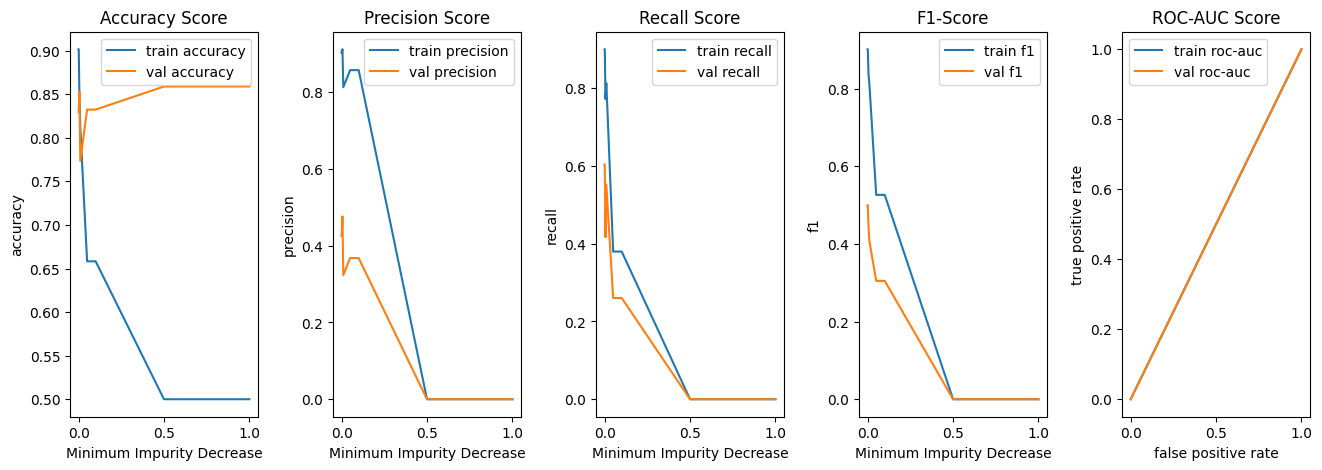

In [56]:
plot_performance(min_impurity_decrease, 'Minimum Impurity Decrease')

### Model After Hyperparameter Tuning

In [57]:
tree_tune = DecisionTreeClassifier(random_state=8, max_depth=10, min_samples_split=10, max_features=None, criterion='entropy', min_impurity_decrease=0)
tree_tune.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10,
                       min_impurity_decrease=0, min_samples_split=10,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.901625   0.902659  0.900342  0.901499  0.970156
Validation Set  0.829412   0.426471  0.604167  0.500000  0.786779


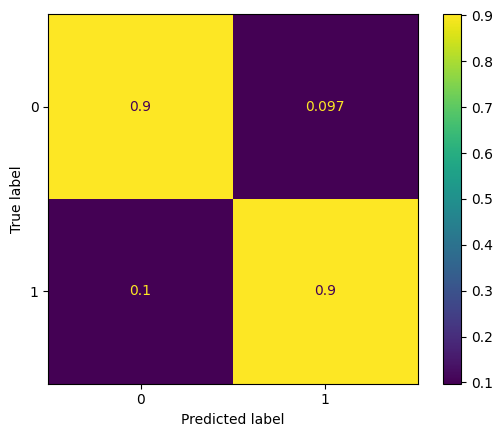

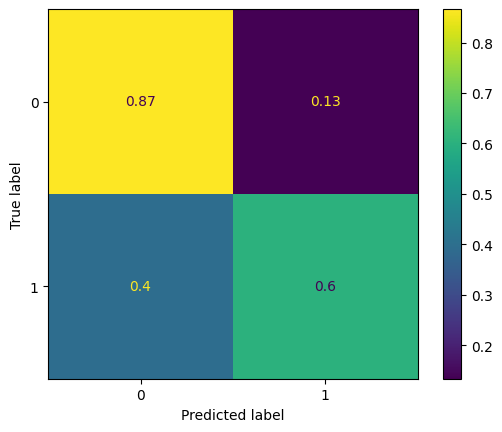

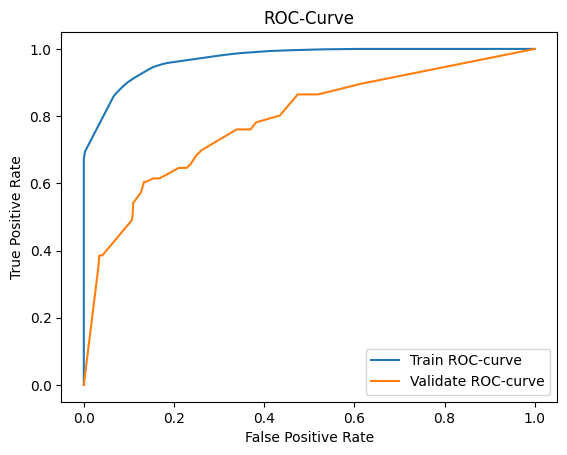

In [58]:
dt_smote = decision_tree(tree_tune)

In [59]:
dump(tree_tune, '../models/decision_tree_smote.joblib')

['../models/decision_tree_smote.joblib']

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [60]:
dt_smote.to_csv('../data/processed/model/3_dt_smote.csv', index=False)

### Without SMOTE (use class_weight = 'balanced')

In [61]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [62]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [63]:
tree = DecisionTreeClassifier(random_state=8, class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.873529   0.560976  0.479167  0.516854  0.708761


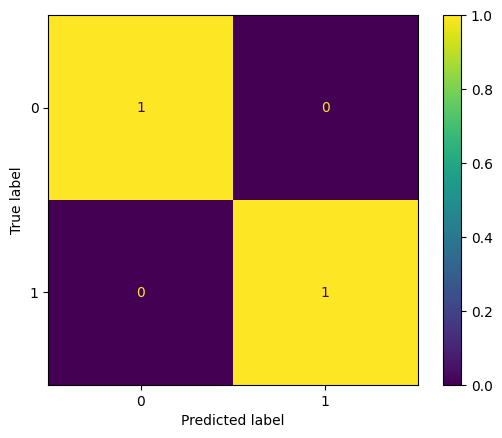

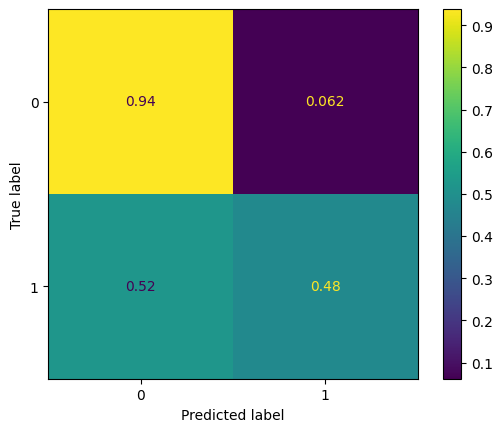

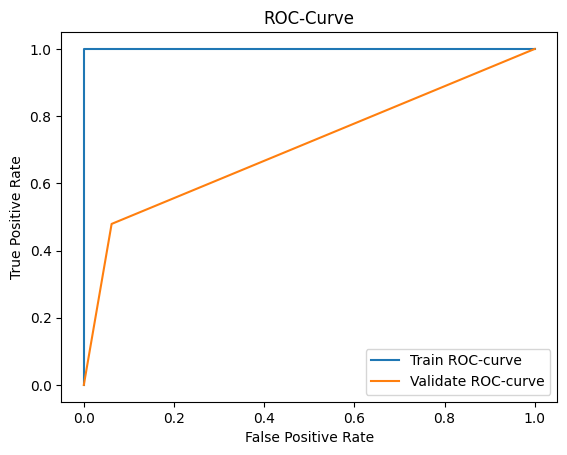

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.873529,0.560976,0.479167,0.516854,0.708761


In [64]:
decision_tree(tree)

### Reduce Overfitting with Max depth

default = None

In [65]:
max_depth = [2, 5, 10, 15, 20, 50, 100, 150, 200, None]

In [66]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    tree = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2.0,0.850735,0.852941,0.474359,0.480000,0.581152,0.500000,0.522353,0.489796,0.746944,0.698701
5.0,0.766912,0.752941,0.356164,0.333333,0.816754,0.750000,0.496025,0.461538,0.872888,0.831059
10.0,0.916912,0.833824,0.643911,0.435115,0.913613,0.593750,0.755411,0.502203,0.977294,0.777246
15.0,0.980882,0.857353,0.883721,0.495050,0.994764,0.520833,0.935961,0.507614,0.998810,0.728248
20.0,0.990809,0.876471,0.938575,0.568182,1.000000,0.520833,0.968314,0.543478,0.999763,0.731271
50.0,1.000000,0.873529,1.000000,0.560976,1.000000,0.479167,1.000000,0.516854,1.000000,0.708761
100.0,1.000000,0.873529,1.000000,0.560976,1.000000,0.479167,1.000000,0.516854,1.000000,0.708761
150.0,1.000000,0.873529,1.000000,0.560976,1.000000,0.479167,1.000000,0.516854,1.000000,0.708761
200.0,1.000000,0.873529,1.000000,0.560976,1.000000,0.479167,1.000000,0.516854,1.000000,0.708761
NaN,1.000000,0.873529,1.000000,0.560976,1.000000,0.479167,1.000000,0.516854,1.000000,0.708761


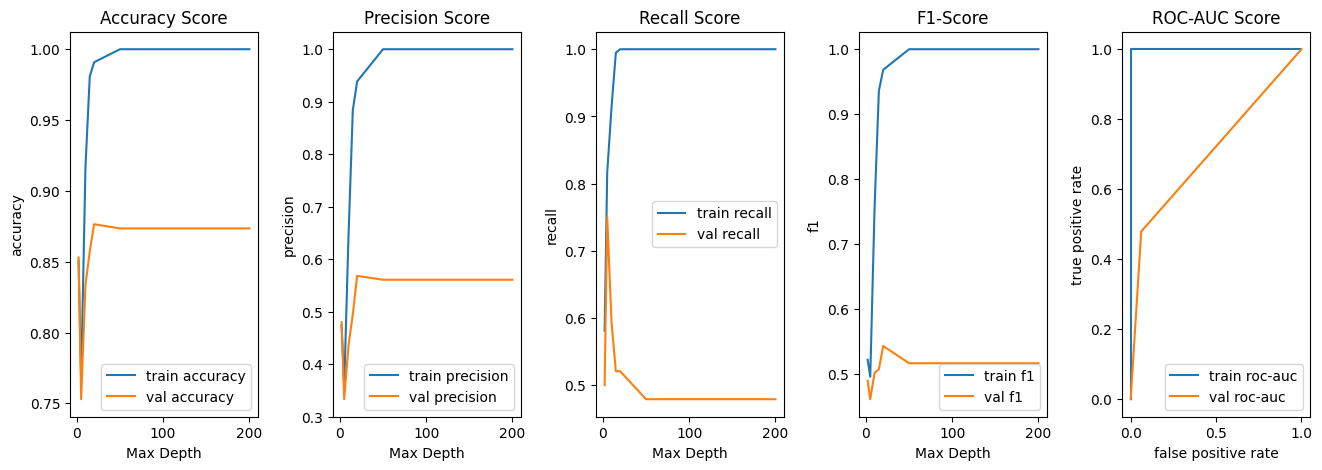

In [67]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 5

In [68]:
tree_max_depth = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5)
tree_max_depth.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.766912   0.356164  0.816754  0.496025  0.872888
Validation Set  0.752941   0.333333  0.750000  0.461538  0.831059


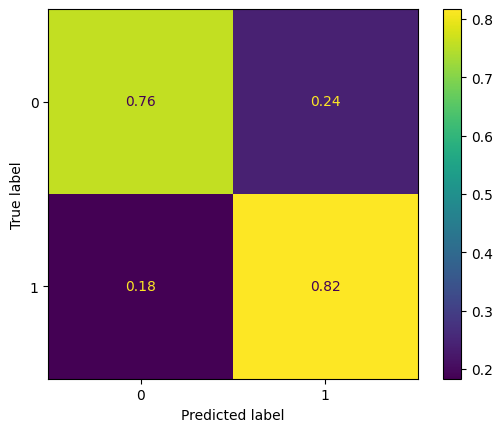

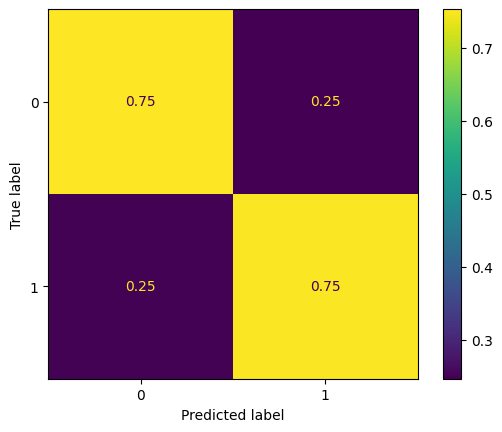

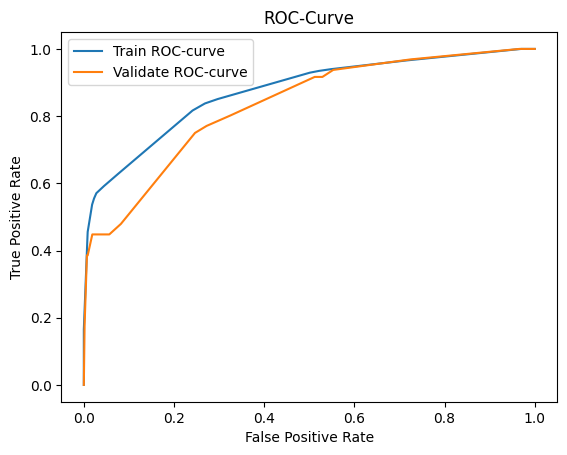

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.752941,0.333333,0.75,0.461538,0.831059


In [69]:
decision_tree(tree_max_depth)

### Reduce Overfitting with min samples split

default = 2

In [70]:
min_samples_split = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [71]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    tree = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.766912,0.752941,0.356164,0.333333,0.816754,0.750000,0.496025,0.461538,0.872888,0.831059
5,0.766912,0.752941,0.356164,0.333333,0.816754,0.750000,0.496025,0.461538,0.872888,0.831059
10,0.764338,0.751471,0.353341,0.331797,0.816754,0.750000,0.493281,0.460064,0.871343,0.830729
20,0.763603,0.751471,0.352542,0.331797,0.816754,0.750000,0.492502,0.460064,0.870912,0.830836
50,0.763603,0.751471,0.352542,0.331797,0.816754,0.750000,0.492502,0.460064,0.870912,0.830836
100,0.766544,0.766176,0.348865,0.347826,0.764398,0.750000,0.479081,0.475248,0.855692,0.827367
150,0.746324,0.747059,0.330396,0.327273,0.785340,0.750000,0.465116,0.455696,0.851737,0.819251
200,0.723897,0.729412,0.310380,0.313559,0.790576,0.770833,0.445756,0.445783,0.838920,0.814435
250,0.723897,0.729412,0.310380,0.313559,0.790576,0.770833,0.445756,0.445783,0.833396,0.813160
300,0.723897,0.729412,0.310380,0.313559,0.790576,0.770833,0.445756,0.445783,0.827363,0.805009


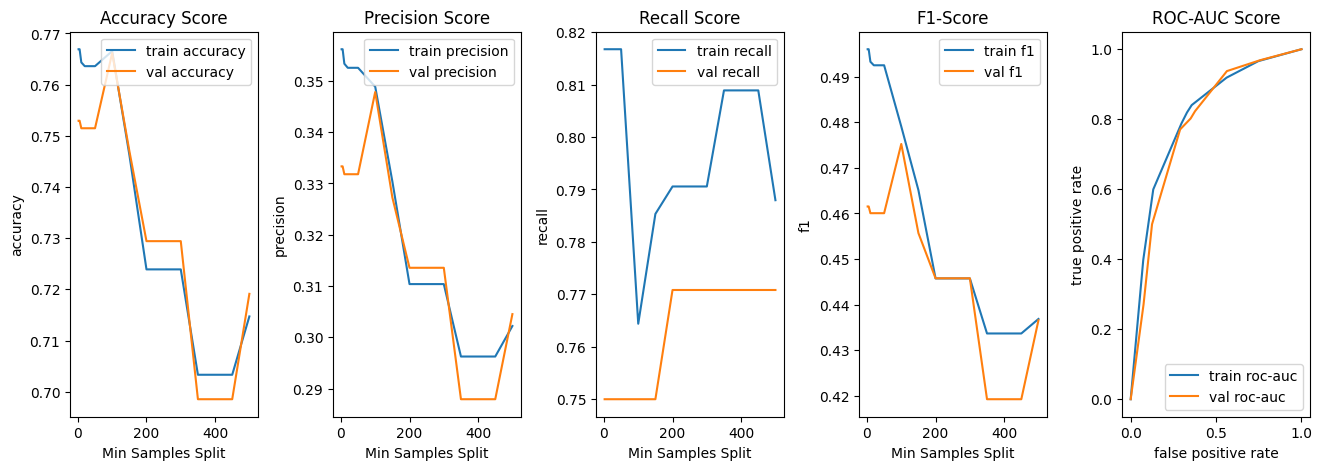

In [72]:
plot_performance(min_samples_split, 'Min Samples Split')

#### min_samples_split = 100

In [73]:
tree_min_samples_split = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=100)
tree_min_samples_split.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=100, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.766544   0.348865  0.764398  0.479081  0.855692
Validation Set  0.766176   0.347826  0.750000  0.475248  0.827367


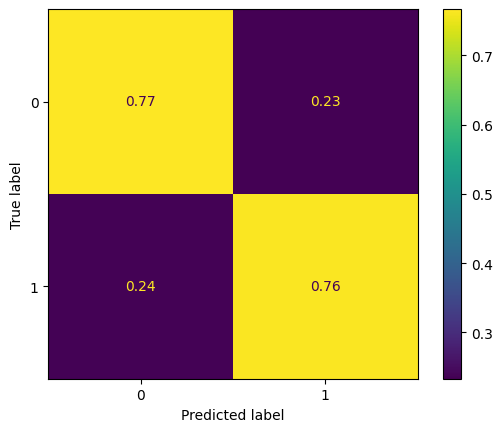

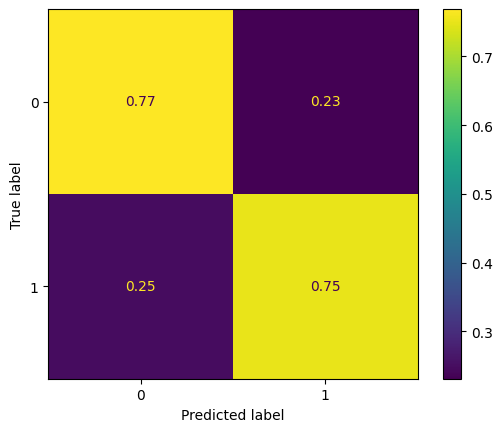

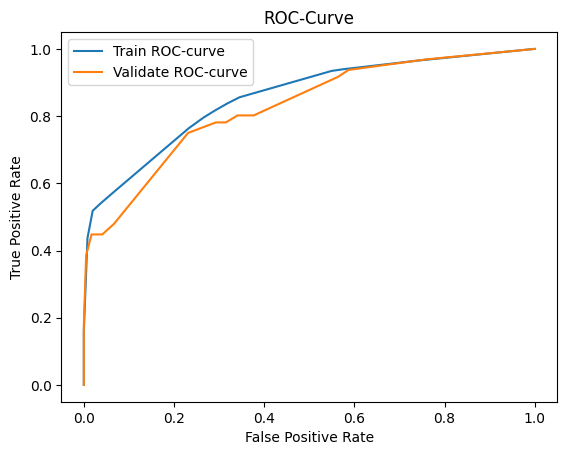

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.766176,0.347826,0.75,0.475248,0.827367


In [74]:
decision_tree(tree_min_samples_split)

### Reduce Overfitting with max_features

default = None

In [75]:
max_features = ['auto', 'sqrt', 'log2', None]

In [76]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    tree = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=100, max_features=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.807721,0.766176,0.381513,0.270073,0.594241,0.385417,0.464688,0.317597,0.784854,0.671500
sqrt,0.807721,0.766176,0.381513,0.270073,0.594241,0.385417,0.464688,0.317597,0.784854,0.671500
log2,0.823529,0.788235,0.406130,0.293103,0.554974,0.354167,0.469027,0.320755,0.778778,0.684682
None,0.766544,0.766176,0.348865,0.347826,0.764398,0.750000,0.479081,0.475248,0.855692,0.827367


### Reduce Overfitting with criterion

default = gini

In [77]:
criterion = ['gini', 'entropy', 'log_loss']

In [78]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in criterion:
    tree = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=100, max_features=None, criterion=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_criterion = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=criterion)

tune_criterion

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
gini,0.766544,0.766176,0.348865,0.347826,0.764398,0.75000,0.479081,0.475248,0.855692,0.827367
entropy,0.779779,0.785294,0.359638,0.367021,0.727749,0.71875,0.481385,0.485915,0.851558,0.804661
log_loss,0.779779,0.785294,0.359638,0.367021,0.727749,0.71875,0.481385,0.485915,0.851558,0.804661


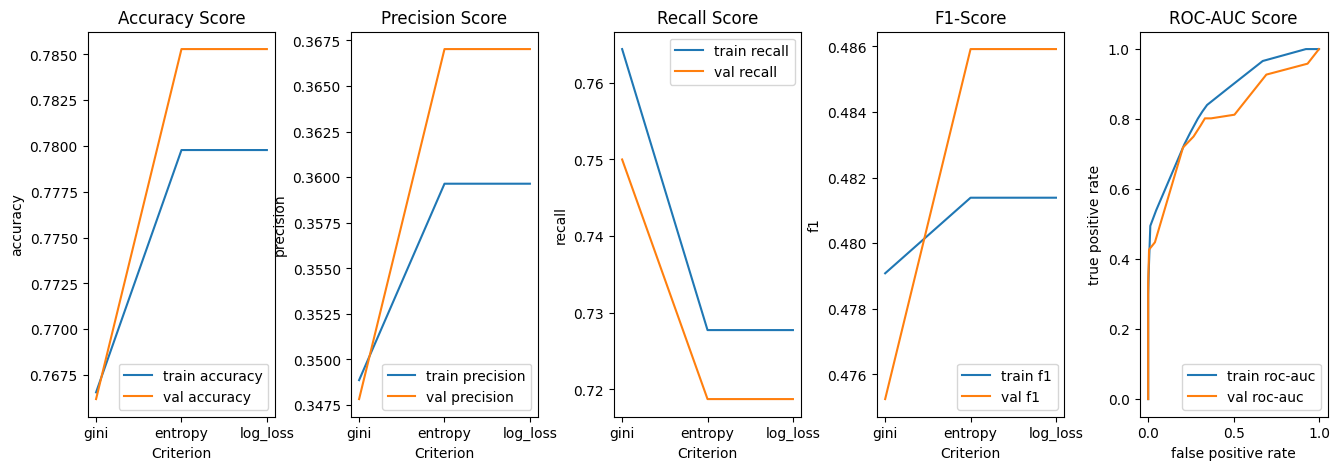

In [79]:
plot_performance(criterion, 'Criterion')

#### criterion = 'entropy'

In [80]:
tree_criterion = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=100, max_features=None, criterion='gini')
tree_criterion.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=100, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.766544   0.348865  0.764398  0.479081  0.855692
Validation Set  0.766176   0.347826  0.750000  0.475248  0.827367


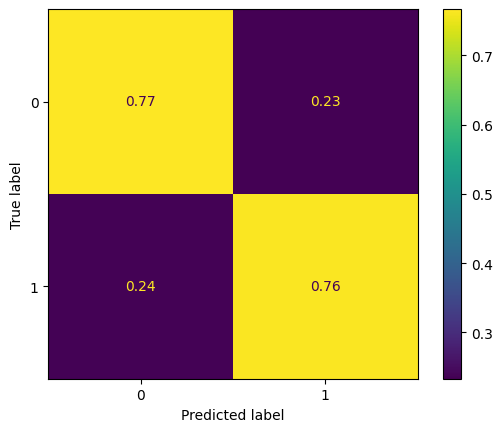

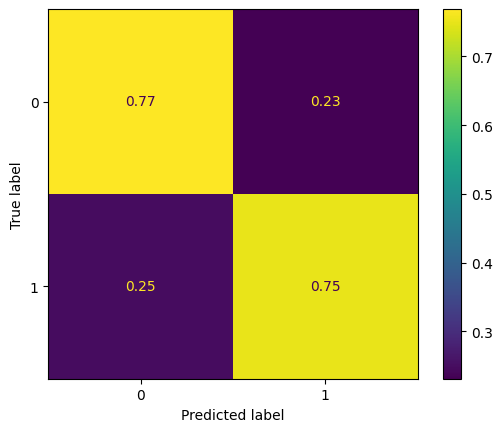

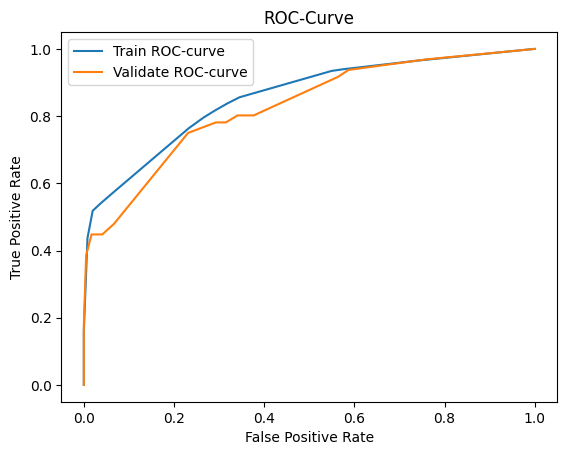

,accuracy,precision,recall,f1-score,roc-auc
Decision Tree,0.766176,0.347826,0.75,0.475248,0.827367


In [81]:
decision_tree(tree_criterion)

### Reduce overfitting with Minimum Impurity Decrease

In [82]:
min_impurity_decrease = [0, 0.00025, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

In [83]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_impurity_decrease:
    tree = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=100, max_features=None, criterion='gini', min_impurity_decrease=i).fit(X_train, y_train)
    y_train_preds = tree.predict(X_train)
    y_val_preds = tree.predict(X_val)
    
    y_train_probs = tree.predict_proba(X_train)[:, 1]
    y_val_probs = tree.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_impurity_decrease = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_impurity_decrease)

tune_impurity_decrease

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.00000,0.766544,0.766176,0.348865,0.347826,0.764398,0.750000,0.479081,0.475248,0.855692,0.827367
0.00025,0.766544,0.766176,0.348865,0.347826,0.764398,0.750000,0.479081,0.475248,0.855692,0.827367
0.00050,0.766544,0.766176,0.348865,0.347826,0.764398,0.750000,0.479081,0.475248,0.855692,0.827367
0.00100,0.765074,0.766176,0.347206,0.347826,0.764398,0.750000,0.477514,0.475248,0.854492,0.827367
0.00500,0.768382,0.764706,0.348780,0.341584,0.748691,0.718750,0.475874,0.463087,0.839380,0.812357
0.01000,0.830147,0.822059,0.425651,0.396694,0.599476,0.500000,0.497826,0.442396,0.737900,0.685591
0.05000,0.852206,0.832353,0.469136,0.371429,0.397906,0.270833,0.430595,0.313253,0.662169,0.597745
0.10000,0.140441,0.141176,0.140441,0.141176,1.000000,1.000000,0.246293,0.247423,0.500000,0.500000
0.50000,0.140441,0.141176,0.140441,0.141176,1.000000,1.000000,0.246293,0.247423,0.500000,0.500000
1.00000,0.140441,0.141176,0.140441,0.141176,1.000000,1.000000,0.246293,0.247423,0.500000,0.500000


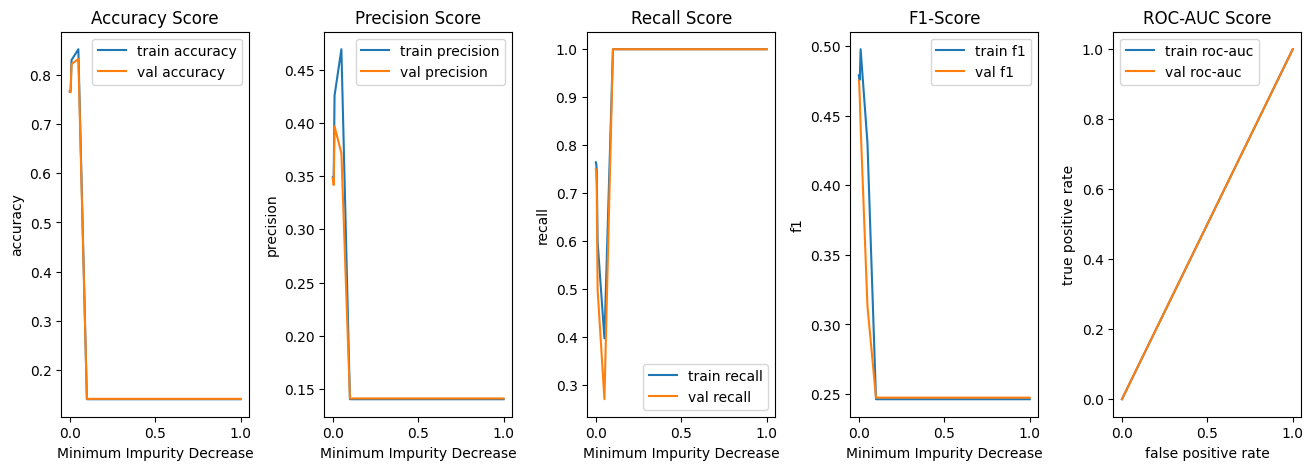

In [84]:
plot_performance(min_impurity_decrease, 'Minimum Impurity Decrease')

### Model After Hyperparameter Tuning

In [85]:
tree_tune = DecisionTreeClassifier(random_state=8, class_weight='balanced', max_depth=5, min_samples_split=100, max_features=None, criterion='gini', min_impurity_decrease=0.0005)
tree_tune.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_impurity_decrease=0.0005, min_samples_split=100,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.766544   0.348865  0.764398  0.479081  0.855692
Validation Set  0.766176   0.347826  0.750000  0.475248  0.827367


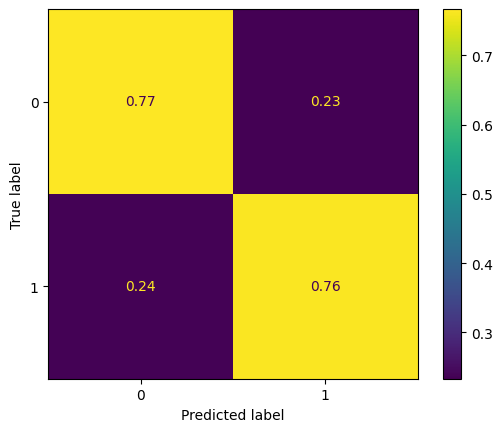

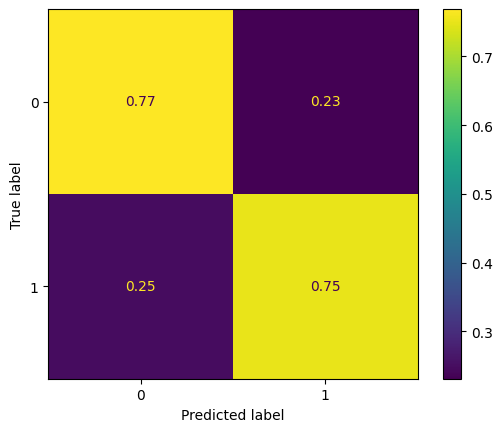

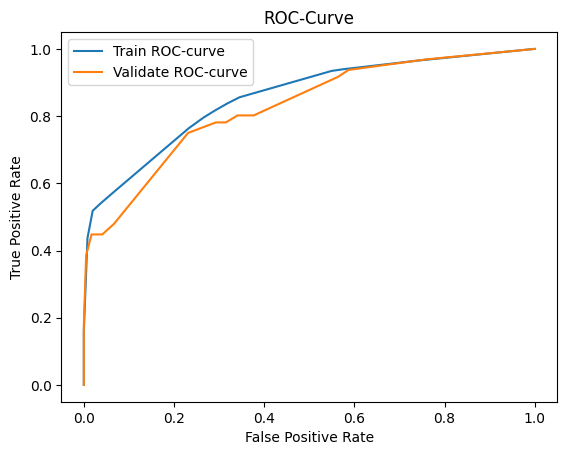

In [86]:
dt = decision_tree(tree_tune)

In [87]:
dump(tree_tune, '../models/decision_tree.joblib')

['../models/decision_tree.joblib']

In [88]:
from sklearn.model_selection import cross_val_score

In [89]:
cv_recall_scores = cross_val_score(tree_tune, X_train, y_train, cv=10, scoring='recall')

In [90]:
print("Cross-Validation Recall Scores:", cv_recall_scores)
print("Mean Recall:", cv_recall_scores.mean())

Cross-Validation Recall Scores: [0.71052632 0.60526316 0.65789474 0.71052632 0.73684211 0.60526316
 0.76315789 0.86842105 0.79487179 0.87179487]
Mean Recall: 0.7324561403508772


In [91]:
def adjust_threshold(model):
    thresholds = np.arange(0.1, 1, 0.1)
    
    all_thresholds = []
    
    for threshold in thresholds:
        y_train_probs = model.predict_proba(X_train)[:, 1]
        y_val_probs = model.predict_proba(X_val)[:, 1]
    
        y_train_preds = (y_train_probs >= threshold).astype(int)
        y_val_preds = (y_val_probs >= threshold).astype(int)
    
        train_accuracy = accuracy_score(y_train, y_train_preds)
        train_precision = precision_score(y_train, y_train_preds)
        train_recall = recall_score(y_train, y_train_preds)
        train_f1 = f1_score(y_train, y_train_preds)
        train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
        val_accuracy = accuracy_score(y_val, y_val_preds)
        val_precision = precision_score(y_val, y_val_preds)
        val_recall = recall_score(y_val, y_val_preds)
        val_f1 = f1_score(y_val, y_val_preds)
        val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
        train_score = pd.DataFrame({
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1-score': train_f1,
            'roc-auc': train_roc_auc}, index=[f'Threshold = {threshold:.1f} - Training Set'])
    
        val_score = pd.DataFrame({
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1-score': val_f1,
            'roc-auc': val_roc_auc}, index=[f'Threshold = {threshold:.1f} - Validation Set'])

        score = pd.concat([train_score, val_score])
        all_thresholds.append(score)
        
    return pd.concat(all_thresholds)

In [92]:
adjust_threshold(tree_tune)

,accuracy,precision,recall,f1-score,roc-auc
Threshold = 0.1 - Training Set,0.141912,0.140648,1.000000,0.246611,0.855692
Threshold = 0.1 - Validation Set,0.141176,0.141176,1.000000,0.247423,0.827367
Threshold = 0.2 - Training Set,0.518382,0.217418,0.934555,0.352767,0.855692
Threshold = 0.2 - Validation Set,0.504412,0.211031,0.916667,0.343080,0.827367
Threshold = 0.3 - Training Set,0.683088,0.288360,0.856021,0.431398,0.855692
Threshold = 0.3 - Validation Set,0.648529,0.259259,0.802083,0.391858,0.827367
Threshold = 0.4 - Training Set,0.683088,0.288360,0.856021,0.431398,0.855692
Threshold = 0.4 - Validation Set,0.648529,0.259259,0.802083,0.391858,0.827367
Threshold = 0.5 - Training Set,0.766544,0.348865,0.764398,0.479081,0.855692
Threshold = 0.5 - Validation Set,0.766176,0.347826,0.750000,0.475248,0.827367


Threshold of 0.2 seems to give the best recall, with 0.93 on the training set and 0.91 on the validation set.

#### Threshold = 0.2

In [93]:
dt.to_csv('../data/processed/model/3_dt.csv', index=False)